# ASSIGNMENT:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

models_path="dataset/models/"
scenes_path="dataset/scenes/"

products_A={i:f"{models_path}ref{i}.png" for i in range(1,15)}
products_B={i:f"{models_path}ref{i}.png" for i in range(15,28)}

scenes_A={i:f"{scenes_path}scene{i}.png" for i in range(1,6)}
scenes_B={i:f"{scenes_path}scene{i}.png" for i in range(6,13)}

## TRACK A

In [3]:
def denoise_image(image, filters):
    '''
    Apply denoising filters to the input image.

    Parameters:
    image (array_like): The input image to be denoised.
    filters (list of dict): A list of dictionaries, each representing a denoising filter to be applied.
        Each dictionary should have the following keys:
            - name (str): The name of the filter.
            - n_iter (int): The number of iterations to apply the filter.
            - params (dict): A dictionary containing parameters specific to the filter.

    Returns:
    array_like: The denoised image.

    Example:
    >>> denoised_image = denoise_image(input_image, [
    >>>     {"name": "mean", "n_iter": 1, "params": {"ksize": 7}},
    >>>     {"name": "median", "n_iter": 1, "params": {"ksize": 5}},
    >>>     {"name": "bilateral", "n_iter": 1, "params": {"d": 3, "sigmaColor": 2, "sigmaSpace": 1.5}},
    >>>     {"name": "gaussian", "n_iter": 1, "params": {"sigmaX": 2}},
    >>>     {"name": "non_local_means", "n_iter": 1, "params": {"templateWindowSize": 5, "searchWindowSize": 21, "h": 3, "hColor": 20}},
    >>>     {"name": "canny", "n_iter": 1, "params": {"threshold1": 5, "threshold2": 21}},
    >>>     {"name": "sharpen", "n_iter": 1, "params": {}}, # 3x3 kernel
    >>>     {"name": "emboss", "n_iter": 1, "params": {}}   # 3x3 kernel
    >>> ])
    '''
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])

                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

def normalize(image):
    return (image.astype(float)*255.0/225.0).astype('uint8')

def  normalize2(image):
    # Calculate new values through linear interpolation
    max_value = np.max(image)
    new_image = np.interp(image, (0, max_value), (0, 255)).astype('uint8')
    return new_image

def normalize3(image):
    return cv2.normalize(image, None, 0,255,cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [4]:
def diagonal(points,point2=None):
    if point2:
        return np.sqrt(np.abs((points[0]-point2[0])**2+(points[1]-point2[1])**2))
    return np.sqrt(np.abs(np.sum(np.subtract(points[:1,:],points[1:,:])**2)))

def get_geometry(corners):
    '''
	return position(x,y), width, height
    '''
    return {'position': tuple(np.round((np.sum(corners,axis=0)/4)[0],0).astype(int)),
        'width': int(f'{diagonal(corners[1:3,:]):0.0f}'),
        'height': int(f'{diagonal(corners[:2,:]):0.0f}')
    }

### Auxiliar mehods used by the printing ones

In [5]:
def inside(center,image_shape): # center is (x;y), shape is (rows,columns)
    '''
    used to detect if a point (the centers of the bounding boxes) is inside the scene image
    '''
    return (center[0]>=0 and center[0]<image_shape[1]) and (center[1]>=0 and center[1]<image_shape[0])


def outside(geometry,image_shape,tollerance): # center is (x;y), shape is (rows,columns)
    '''
    used to detect if any point of the bounding box is outside of the image
    '''
    cx,cy=geometry['position']
    w=geometry['width']
    h=geometry['height']
    L=cx-w/2
    R=cx+w/2
    U=cy-h/2
    D=cy+h/2
    return L<=-tollerance or R>image_shape[1]+tollerance or U<=-tollerance or D>image_shape[0]+tollerance

def check_Boundings(point,geometry):
    '''
	checks wheter or not a point is inside a bounding box (computed using `get_geometry`)
    '''
    try:
        pointX,pointY=point
        centerX,centerY=geometry['position']
        sizeX=geometry['width']
        sizeY=geometry['height']
        return (centerX-sizeX/2<=pointX and pointX<=centerX+sizeX/2) and (centerY-sizeY/2<=pointY and pointY<=centerY+sizeY/2)
    except ValueError:
        return False
    

def reflag_single_products(results):
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product in keys:
            results[scene][product]['flag'] = True


def flag_same_products_SI(results,method='overlapping_center',method_param=50,show_actions=False):
    '''
    Single Instance:
	for every couple of products in the same scene, if two products happen
      to be in the same region, only keep the one with the most matches
    '''
    for scene in results.keys():
        keys=list(results[scene].keys())
        for product1 in keys:
            for product2 in [k for k in keys if k!=product1]:
                match method:
                    case 'center_vicinity':
                        if diagonal(results[scene][product1]["geometry"]["position"],results[scene][product2]["geometry"]["position"]) < method_param:
                            if show_actions:
                                print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                            if results[scene][product1]["match_count"] > results[scene][product2]["match_count"]:
                                if results[scene][product1]['flag']:
                                    results[scene][product2]["flag"]=False
                            else:
                                if results[scene][product2]["flag"]:
                                    results[scene][product1]["flag"]=False
                    case 'overlapping_center':
                        point = results[scene][product1]["geometry"]["position"] # tuple (x,y)
                        if check_Boundings(point,results[scene][product2]["geometry"]):
                            if show_actions:
                                print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                            if results[scene][product1]["match_count"] > results[scene][product2]["match_count"]:
                                if results[scene][product1]['flag']:
                                    results[scene][product2]["flag"]=False
                            else:
                                if results[scene][product2]["flag"]:
                                    results[scene][product1]["flag"]=False
                            
                    case _:
                        pass

### Printing methods

In [6]:
def display_settings(settings,value=None):
    '''
    print used filters and additional settings
    '''
    aux=[filter for filter in settings if ( 'matching_settings' in filter.keys() or filter['n_iter']>0)]
    if value:
        print(f'tollerance on template matcher: {value}')
    display(aux)



def print_single_instances(results: dict,min_match,check_pos,return_dict=False):
    # variables used to format the string
    max_product_len = max(len(str(product)) for scene in results for product in results[scene].keys())
    max_match_len = max(len(str(results[scene][product]["match_count"])) for scene in results for product in results[scene])
    max_x_len = max(len(str(results[scene][product]["geometry"]["position"][0])) for scene in results for product in results[scene] if inside(results[scene][product]['geometry']['position'], scenes_info_A[scene][2]))
    max_y_len = max(len(str(results[scene][product]["geometry"]["position"][1])) for scene in results for product in results[scene] if inside(results[scene][product]['geometry']['position'], scenes_info_A[scene][2]))
    max_width_len = max(len(str(results[scene][product]["geometry"]["width"])) for scene in results for product in results[scene])
    
    max_height_len = max(len(str(results[scene][product]["geometry"]["height"])) for scene in results for product in results[scene])
    if return_dict:
        results_dict={}

    for scene in results.keys():
        if return_dict:
            results_dict[scene]={}
        print(f'Scene {scene}:')
        for product in results[scene].keys():
            if (# the product must have a certain amount of matches
                results[scene][product]['match_count'] >= min_match and 
                 #set to false in `flag_same_products_SI` if refs refers to the same product (they both think to be the same product) 
                results[scene][product]['flag'] and
                ( # check the position if you have to
                    (not check_pos) or 
                    inside(results[scene][product]['geometry']['position'], scenes_info_A[scene][2])
                )):
                if return_dict:
                    results_dict[scene][product]=results[scene][product]
                print(f"\tProduct {str(product)+',':<{max_product_len+1}}"
                    + f" matches: {str(results[scene][product]['match_count'])+',':<{max_match_len+1}}"
                    + f" {{position: ({str(results[scene][product]['geometry']['position'][0])+',':<{max_x_len+1}}"
                    + f" {str(results[scene][product]['geometry']['position'][1])+'),':<{max_y_len}}"
                    + f" width: {str(results[scene][product]['geometry']['width'])+'px,':<{max_width_len}}"
                    + f" height: {str(results[scene][product]['geometry']['height'])+'px':<{max_height_len-1}}}}")
    if return_dict:
        return results_dict

### RESULTS

### Draw bounding boxes:

In [7]:
def get_angles(geometry_dict):
    '''
    return the angles with shape (4,1,2)
    '''
    center_x, center_y = geometry_dict['position']
    width = geometry_dict['width']
    height = geometry_dict['height']
    
    top_left = np.array([center_x - width/2, center_y + height/2])
    bottom_left = np.array([center_x - width/2, center_y - height/2])
    bottom_right = np.array([center_x + width/2, center_y - height/2])
    top_right = np.array([center_x + width/2, center_y + height/2])
    corners = np.array([top_left, bottom_left, bottom_right, top_right]).reshape(4, 1, 2)
    
    return corners


def get4corners(tl, br):
    tl_x, tl_y = tl
    br_x, br_y = br
    tr_x, tr_y = br_x, tl_y
    bl_x, bl_y = tl_x, br_y

    return np.array([[tl_x, tl_y], [bl_x, bl_y], [br_x, br_y], [tr_x, tr_y]]).reshape((4,1,2))
    

## TRACK B

In [8]:
EQUAL_GRAY_CONVERT=False

In [50]:
# Working settings: ANCHE 1-1-1 OPPURE --->102<---questo col window
# [{'name': 'median', 'n_iter': 1, 'params': {'ksize': 3}},
#  {'name': 'median', 'n_iter': 0, 'params': {'ksize': 5}},
#  {'name': 'median', 'n_iter': 1, 'params': {'ksize': 7}},
#  {'matching_settings': {'min_match': 5,
#    'check_position': 'overlapping_center'}}]
# {'d': 5, 'n_iter': 1, 'name': 'bilateral', 'sigmaColor': 130, 'sigmaSpace': 40}, {'ksize': 3, 'n_iter': 2, 'name': 'median'}, {'ksize': 5, 'n_iter': 2, 'name': 'median'}
settings_B = [
    {'name': "median",
        "n_iter": 2,
        "params": {"ksize": 3}
     },
    {'name': "median",
        "n_iter": 0,
        "params": {"ksize": 5}
     },
    {'name': "median",
        "n_iter": 1,
        "params": {"ksize": 7}
     },
    # {'name': "median",
    #     "n_iter": 0,
    #     "params": {"ksize": 9}
    #  },
    # {'name': "non_local_means",
    #     "n_iter": 0,
    #     "params": {'templateWindowSize':14,"searchWindowSize":21, "h":10, "hColor": 20}
    #  },
]

SHOW_KEYPOINTS = False
SHOW_FILTERED = False

if SHOW_KEYPOINTS or SHOW_FILTERED:
    fig, axes = plt.subplots(4, 2, figsize=(14, 20))
    axes = axes.flatten()

scenes_info_B = {}
read_scenes_B = {}

for i, scene in enumerate(scenes_B):
    image = cv2.imread(scenes_B[scene])
    filtered_image = denoise_image(image, settings_B)
    if EQUAL_GRAY_CONVERT:
        image=np.mean(image,axis=2).astype(np.uint8)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(filtered_image)
    filtered_image = normalize2(filtered_image)
    read_scenes_B[scene]=filtered_image
    scenes_info_B[scene]=list(sift.compute(filtered_image, keypoints))+[image.shape]
    if SHOW_KEYPOINTS or SHOW_FILTERED:
        printable_image = image
        if SHOW_FILTERED:
            printable_image = filtered_image
        if SHOW_KEYPOINTS:
            printable_image = cv2.drawKeypoints(
                filtered_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(printable_image,cv2.COLOR_BGR2RGB))
        axes[i].set_title(scenes_B[scene][len(scenes_path):])
        # remove unused subplots
        if i == len(scenes_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS or SHOW_FILTERED:
    plt.tight_layout()
    plt.show()

In [51]:
products_info_B = {}
read_products_B={}
read_denoised_products_B={}
SHOW_KEYPOINTS=False
if SHOW_KEYPOINTS:
    fig, axes = plt.subplots(3, 5, figsize=(14, 20))
    axes = axes.flatten()

for i, product in enumerate(products_B):
    image = cv2.imread(products_B[product])
    read_products_B[product]=image
    # image_noise=np.clip(image-np.random.normal(scale=100,size=image.shape),0,225).astype(np.uint8)
    # image_noise=denoise_image(image_noise,settings_B)
    # read_denoised_products_B[product]=image_noise
    if EQUAL_GRAY_CONVERT:
        image=np.mean(image,axis=2).astype(np.uint8)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(image)
    products_info_B[product]=list(sift.compute(image, keypoints))+[image.shape]
    if SHOW_KEYPOINTS:
        img_kp = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axes[i].imshow(cv2.cvtColor(img_kp,cv2.COLOR_RGB2BGR))
        axes[i].axis('off')
        axes[i].set_title(products_B[product][len(models_path):])
        if i==len(products_B)-1:
            for ax in axes[i+1:]:
                ax.axis('off')

if SHOW_KEYPOINTS:
    plt.tight_layout()
    plt.show()

In [52]:
# possibilities: HISTCMP_CORREL, HISTCMP_CHISQR, HISTCMP_INTERSECT, HISTCMP_BHATTACHARYYA, HISTCMP_HELLINGER, HISTCMP_CHISQR_ALT, HISTCMP_KL_DIV
def get_histogram_score(product, scene, homography_geometry, method = cv2.HISTCMP_INTERSECT):
    PLOT = False
    # if we want to use an higher number of bins (possibly up to 256(0, 255) it won't be possible to use HISTCMP_CORREL as metric
    # with the images we're using, since they're quite big and the compare method will return nan
    hist_sizes = [16, 16, 16]  
    ranges = [0, 256, 0, 256, 0, 256]
    product_image = read_products_B[product]
    scene_image = read_scenes_B[scene]
    scene_corners = get_angles(homography_geometry)
    
    # Slicing images where product is found
    row_min = min(max(int(min(a[0][1] for a in scene_corners)), 0), scene_image.shape[0]-1)
    row_max = max(min(int(max(a[0][1] for a in scene_corners)), scene_image.shape[0]-1),0)
    col_min = min(max(int(min(a[0][0] for a in scene_corners)), 0), scene_image.shape[1]-1)
    col_max = max(min(int(max(a[0][0] for a in scene_corners)), scene_image.shape[1]-1),0)
    scene_image = scene_image[row_min:row_max+1, col_min:col_max+1]
    
    # Computing histograms
    product_hists = cv2.calcHist([product_image], [0,1,2], None, hist_sizes, ranges)
    scene_hists = cv2.calcHist([scene_image], [0,1,2], None, hist_sizes, ranges)
        
    title = f'(x,y):{homography_geometry["position"]}, dim:{homography_geometry["width"]} x {homography_geometry["height"]}\n'
    for i in range(6):    
        title += f'{i}: {cv2.compareHist(product_hists, scene_hists, i):.2f} '
    if PLOT:
        fig = plt.figure(figsize=(20,5))
        fig.suptitle(title)
        plt.subplot(2,2,1)
        plt.imshow(cv2.cvtColor(product_image,cv2.COLOR_BGR2RGB))
        plt.subplot(2,2,2)
        plt.imshow(cv2.cvtColor(scene_image,cv2.COLOR_BGR2RGB))
        plt.subplot(2,2,3)
        chans = cv2.split(product_image)
        colors = ("b", "g", "r")
        # loop over the image channels
        for (chan, color) in zip(chans, colors):
            # create a histogram for the current channel and plot it
            hist = cv2.calcHist([chan], [0], None, [hist_sizes[0]], ranges[0:2])
            plt.plot(hist, color=color)
            plt.yscale('log')
            plt.grid()
            
        #Same for scenes
        plt.subplot(2,2,4)
        chans = cv2.split(scene_image)
        for (chan, color) in zip(chans, colors):
            hist = cv2.calcHist([chan], [0], None, [hist_sizes[0]], ranges[0:2])
            plt.plot(hist, color=color)
            plt.yscale('log')
            plt.grid()

    # Normalize the histograms
    # cv2.normalize(product_hists, product_hists)
    # cv2.normalize(scene_hists, scene_hists)

    # Compare the histograms
    score = cv2.compareHist(product_hists, scene_hists, method)
    
    return score

In [53]:
# to be fair basta vedere solo il centro tanto sono
# tutte larghe ed alte uguale per via della window
def close_geometries(geom1,geom2,tolerance=40):
    if (abs(geom1['position'][0] - geom2['position'][0]) <= tolerance and
        abs(geom1['position'][1] - geom2['position'][1]) <= tolerance and
        abs(geom1['width'] - geom2['width']) <= tolerance and
        abs(geom1['height'] - geom2['height']) <= tolerance):
        return True
    return False

In [54]:
PRINT_PROGRESS=True	

MIN_RESULT_VALUE = 0.27
# resulting matches/positions will be stored here
results_B = {}
for scene in scenes_info_B:
    if scene ==10: # TODO da togliere
        # continue
        pass
    results_B[scene] = {}

    best=0
    geom={}
    prod=0
    # find best product to use to get the dimensions of the window
    if PRINT_PROGRESS:print(f'----------SCENE {scene}----------')
    for product in products_info_B:
        try:
            matcher = cv2.BFMatcher()
            matches = matcher.knnMatch(products_info_B[product][1], scenes_info_B[scene][1], k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.8*n.distance:
                    good.append(m)
            src_pts = np.float32([products_info_B[product][0][m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([scenes_info_B[scene][0][m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()
            h, w = products_info_B[product][2][:2]
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1],[w-1, 0]]).reshape(-1, 1, 2)
            dst = np.int32(cv2.perspectiveTransform(pts, M))
            matches=np.sum(matchesMask)
            if matches>best:
                prod=product
                best=matches
                geom=get_geometry(dst)
            if PRINT_PROGRESS:print(f'matches for product {product}: {matches}')
        except: 
            print('\terror on SIFT')
            # continue
    try:
        w=geom['width']
        h=geom['height']
    except:
        print('error with geom dict')

    if PRINT_PROGRESS:print('=======',f'best product found for scene {scene} is {prod} with {best} matches, size is w:{w}, h:{h}')
    # now use that window to compute template matching
    for product in products_info_B:
        positions_used=[]
        if product not in (18,19): # TODO da togliere
            # continue
            pass
        results_B[scene][product]=[]
        # resize the product with the found dimension
        try:
            if PRINT_PROGRESS:print(f'matching {product} on scene {scene}')
            resized_product=cv2.resize(read_products_B[product],(w,h),interpolation=1)
            # search the template
            result = cv2.matchTemplate(read_scenes_B[scene], resized_product, cv2.TM_CCOEFF_NORMED)
            locations = np.where(result >= MIN_RESULT_VALUE)
            for loc in zip(*locations[::-1]):
                top_left=loc
                bottom_right=(top_left[0] + resized_product.shape[1], top_left[1] + resized_product.shape[0])
                angles=get4corners(top_left,bottom_right)
                geom=get_geometry(angles)

                # only append this box if it is in a position of a possible next product, 
                # and not in the same spot again
                interrupt=False
                if len(positions_used) > 0:
                    # new method: check if the current geom is 'similar'to one already stored
                    for old_geom in positions_used:
                        if close_geometries(geom,old_geom):
                            interrupt=True
                            break
                        
                if interrupt:
                    continue
                # print(geom['position'])
                results_B[scene][product].append({
                    'match_count': np.inf,
                    'geometry': geom,
                    'flag':True,
                    'score': get_histogram_score(product,scene, homography_geometry=geom, method=cv2.HISTCMP_INTERSECT)
                    # 'score':1 
                    }
                )
                positions_used.append(geom)
            if PRINT_PROGRESS: print(f'trovate {len(results_B[scene][product])} istanze')
        except cv2.error:
            print('\terror on matcher',cv2.error)
        # except KeyboardInterrupt:
        #     # print(positions_used)
        #     pass


----------SCENE 6----------
matches for product 15: 29
matches for product 16: 6
matches for product 17: 8
	error on SIFT
matches for product 19: 6
matches for product 20: 6
matches for product 21: 5
matches for product 22: 4
matches for product 23: 7
matches for product 24: 7
matches for product 25: 4
matches for product 26: 6
	error on SIFT
======= best product found for scene 6 is 15 with 29 matches, size is w:327, h:905
matching 15 on scene 6
trovate 30 istanze
matching 16 on scene 6
trovate 0 istanze
matching 17 on scene 6
trovate 0 istanze
matching 18 on scene 6
trovate 0 istanze
matching 19 on scene 6
trovate 0 istanze
matching 20 on scene 6
trovate 0 istanze
matching 21 on scene 6
trovate 0 istanze
matching 22 on scene 6
trovate 0 istanze
matching 23 on scene 6
trovate 0 istanze
matching 24 on scene 6
trovate 0 istanze
matching 25 on scene 6
trovate 0 istanze
matching 26 on scene 6
trovate 0 istanze
matching 27 on scene 6
trovate 0 istanze
----------SCENE 7----------
matches fo

### Auxiliar mehods used by the printing ones

In [55]:
def get_average_color(product=None, scene=None,processed=True):
    if product:
        if product in products_A:
            if processed:
                product = read_denoised_products_A[product]
            else:
                product = read_products_A[product]
        else:
            if processed:
                product = read_denoised_products_B[product]
            else:
                product = read_products_B[product]
        return np.mean(product)
    if scene:
        if scene in scenes_A:
            scn = read_scenes_A[scene]
        else:
            scn = read_scenes_B[scene]
        return np.mean(scn)
    return 0


def get_average_of_zone(geometry, scene):
    angles = get_angles(geometry)
    if scene in scenes_A:
        scn = read_scenes_A[scene]
    else:
        scn = read_scenes_B[scene]
    row_min = min(max(int(min(a[0][1] for a in angles)), 0), scn.shape[0]-1)
    row_max = max(min(int(max(a[0][1] for a in angles)), scn.shape[0]-1),0)
    col_min = min(max(int(min(a[0][0] for a in angles)), 0), scn.shape[1]-1)
    col_max = max(min(int(max(a[0][0] for a in angles)), scn.shape[1]-1),0)
    mean=np.mean(scn[row_min:row_max+1, col_min:col_max+1])
    if np.isnan(mean):
        print(angles)
        print(row_min,row_max,col_min,col_max,scn.shape)
    return mean


def get_average_color_noisy(product=None, scene=None, noise=None):
    if product:
        if product in products_A:
            product = read_products_A[product]
        else:
            product = read_products_B[product]
        if noise is not None:
            product=np.clip(product-noise,0,255).astype(np.uint8)
        return np.mean(product)
    if scene:
        if scene in scenes_A:
            scn = read_noisy_scenes_A[scene]
        else:
            scn = read_noisy_scenes_B[scene]
        return np.mean(scn)
    return 0


def get_average_of_zone_noisy(geometry, scene):
    angles = get_angles(geometry)
    if scene in scenes_A:
        scn = read_noisy_scenes_A[scene]
    else:
        scn = read_noisy_scenes_B[scene]
    row_min = min(max(int(min(a[0][1] for a in angles)), 0), scn.shape[0]-1)
    row_max = max(min(int(max(a[0][1] for a in angles)), scn.shape[0]-1),0)
    col_min = min(max(int(min(a[0][0] for a in angles)), 0), scn.shape[1]-1)
    col_max = max(min(int(max(a[0][0] for a in angles)), scn.shape[1]-1),0)
    mean=np.mean(scn[row_min:row_max+1, col_min:col_max+1])
    if np.isnan(mean):
        print(angles)
        print(row_min,row_max,col_min,col_max,scn.shape)
    return mean

In [56]:
def remove_overlapping_products(results,method='color_center',method_param=75,show_actions = False):
    '''
    Multiple Instance:
	for every couple of instances in the same scene, if two products happen
      to be in the same region, only keep the one with the most matches.

      method='overlapping_center'means that we search for bounding boxes whith
      center inside another bounding box, if so only keep the one with the most 
      number of matches
    '''
    for scene in results:
        keys=results[scene]
        for product1 in keys:
            noise1=None
            if method=='noisy_color_similarity':
                shape=products_info_B[product1][2]
                noise1=np.random.randint(-method_param,method_param,shape)+method_param
            for product2 in keys:
                noise2=None
                if method=='noisy_color_similarity':
                    shape=products_info_B[product2][2]
                    noise2=np.random.randint(-method_param,method_param,shape)+method_param
                for instance1 in range(len(results[scene][product1])):
                    if not results[scene][product1][instance1]["flag"]: # if products are already flagged, do not compute them
                        continue
                    for instance2 in range(len(results[scene][product2])):
                        if not results[scene][product2][instance2]["flag"]: # if products are already flagged, do not compute them
                            continue
                        if product1==product2 and instance1==instance2: # if we check a product with himself
                            continue
                        match method:
                            case 'center_vicinity':
                                if diagonal(results[scene][product1][instance1]["geometry"]["position"],results[scene][product2][instance2]["geometry"]["position"]) < method_param:
                                    if show_actions:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if results[scene][product1][instance1]["match_count"] > results[scene][product2][instance2]["match_count"]:
                                        if results[scene][product1][instance1]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product1][instance1]["flag"] = False
                            case 'overlapping_center':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    if show_actions:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if results[scene][product1][instance1]["match_count"] > results[scene][product2][instance2]["match_count"]:
                                        if results[scene][product1][instance1]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product1][instance1]["flag"] = False
                            case 'color_similarity':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    prod1=get_average_color(product=product1)
                                    zone1=get_average_of_zone(results[scene][product1][instance1]['geometry'],scene)
                                    prod2=get_average_color(product=product2)
                                    zone2=get_average_of_zone(results[scene][product2][instance2]['geometry'],scene)
                                    # print(prod1,zone1,prod2,zone2)
                                    if show_actions:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if np.abs(prod1-zone1) < np.abs(prod2-zone2):
                                        # print(results[scene][product1][instance1])
                                        # print(results[scene][product2][instance2])
                                        if results[scene][product1][instance1]["flag"]:
                                            # print(f'scene {scene}\n',product1,results[scene][product1][instance1]['geometry'],np.abs(prod1-zone1))
                                            # print(product2,results[scene][product2][instance2]['geometry'],np.abs(prod2-zone2))
                                            results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"]:
                                            # print(f'scene {scene}',product1,results[scene][product1][instance1]['geometry'],np.abs(prod1-zone1))
                                            # print(product2,results[scene][product2][instance2]['geometry'],np.abs(prod2-zone2))
                                            results[scene][product1][instance1]["flag"] = False
                            case 'noisy_color_similarity':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    prod1=get_average_color_noisy(product=product1,noise=noise1)
                                    zone1=get_average_of_zone_noisy(results[scene][product1][instance1]['geometry'],scene)
                                    prod2=get_average_color_noisy(product=product2,noise=noise2)
                                    zone2=get_average_of_zone_noisy(results[scene][product2][instance2]['geometry'],scene)
                                    # print(prod1,zone1,prod2,zone2)
                                    if show_actions:
                                        print(f'scene {scene}: products {product1} and {product2} are found to be concentric')
                                    if np.abs(prod1-zone1) < np.abs(prod2-zone2):
                                        # print(results[scene][product1][instance1])
                                        # print(results[scene][product2][instance2])
                                        if results[scene][product1][instance1]["flag"]:
                                            # print(f'scene {scene}\n',product1,results[scene][product1][instance1]['geometry'],np.abs(prod1-zone1))
                                            # print(product2,results[scene][product2][instance2]['geometry'],np.abs(prod2-zone2))
                                            results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"]:
                                            # print(f'scene {scene}',product1,results[scene][product1][instance1]['geometry'],np.abs(prod1-zone1))
                                            # print(product2,results[scene][product2][instance2]['geometry'],np.abs(prod2-zone2))
                                            results[scene][product1][instance1]["flag"] = False
                            case 'histogram_comparing':
                                point=results[scene][product1][instance1]["geometry"]["position"] # tuple (x,y)
                                if check_Boundings(point,results[scene][product2][instance2]["geometry"]):
                                    score1 = results[scene][product1][instance1]["score"]
                                    score2 = results[scene][product2][instance2]["score"]
                                    if show_actions:
                                        print(f'{scene}: {product1, point} and {product2,results[scene][product2][instance2]["geometry"]["position"]} concentric:\n1:{score1} - 2: , {score2}')
                                    if np.abs(score1) > np.abs(score2):
                                        if results[scene][product1][instance1]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product2][instance2]["flag"] = False
                                    else:
                                        if results[scene][product2][instance2]["flag"] and not(product1==product2 and instance1==instance2):
                                          results[scene][product1][instance1]["flag"] = False

                            case _:pass
                                

def remove_wrong_products(results,check_pos=False,exceeding_tol=0,area_tresh=0,min_count=0):
    reflag_products(results)
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                # check if the bounding box goes out of the scene
                if check_pos and outside(results[scene][product][instance]['geometry'],scenes_info_B[scene][2],exceeding_tol):
                    results[scene][product][instance]['flag'] = False
                # check if the bounding box is not smaller than a certain value
                w=results[scene][product][instance]['geometry']['width']
                h=results[scene][product][instance]['geometry']['height']
                if w*h<area_tresh:
                    results[scene][product][instance]['flag'] = False
                # remove bounding boxes with low count
                if results[scene][product][instance]['match_count']<min_count:
                    results[scene][product][instance]['flag'] = False                    


def reflag_products(results):
    for scene in results:
        keys=results[scene]
        for product in keys:
            for instance in range(len(results[scene][product])):
                results[scene][product][instance]['flag'] = True

In [57]:
def a(results,method,method_param=0):
    for scene in results:
        for product in results[scene]:
            for instance in results[scene][product]:
                # instance is the object of the list
                # so oyu can do instance['flag'] and so on
                pass


### Print methods

In [58]:
def print_multiple_instances(results: dict,return_dict=False,order=True):
    max_product_len = max(len(str(product)) for scene in results for product in results[scene])
    max_instance_len = max(len(str(len(results[scene][product]))) for scene in results for product in results[scene])
    max_match_len = max(len(str(product["match_count"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_score_len = max(len(str(product["score"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_x_len = max(len(str(product["geometry"]["position"][0])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scenes_info_B[scene-1][2]))
    max_y_len = max(len(str(product["geometry"]["position"][1])) for scene in results for products in results[scene] for product in results[scene][products])# if inside(product['geometry']['position'], scenes_info_B[scene-1][2]))
    max_width_len = max(len(str(product["geometry"]["width"])) for scene in results for products in results[scene] for product in results[scene][products])
    max_height_len = max(len(str(product["geometry"]["height"])) for scene in results for products in results[scene] for product in results[scene][products])

    if return_dict:
        results_dict={}

    for i,scene in enumerate(results):
        if return_dict:
            results_dict[scene]={}
        print(f'Scene {scene}:')
        for products in results[scene]:
            printable_prods=[]
            for instance in results[scene][products]:
                if instance['flag']:
                    printable_prods.append(instance)
            num_inside=len(printable_prods)
            if num_inside>0:
                if return_dict:
                    results_dict[scene][products]=[]
                print(f"\tProduct {products:<{max_product_len}} - {num_inside} instance found:")
                if order: printable_prods = sorted(printable_prods, key=lambda instance: instance['geometry']["position"][0])
                for i,instance in enumerate(printable_prods,1):
                    if return_dict:
                        results_dict[scene][products].append(instance)
                    print(
                    f"\t\tInstance {str(i)+',':<{max_instance_len}}"
                    # + f" matches: {str(instance['match_count'])+',':<{max_match_len+1}}"
                    + f" score: {str(instance['score'])+',':<{max_score_len+1}}"
                    + f" {{position: ({str(instance['geometry']['position'][0])+',':<{max_x_len+1}}"
                    + f" {str(instance['geometry']['position'][1])+'),':<{max_y_len}}"
                    + f" width: {str(instance['geometry']['width'])+'px,':<{max_width_len}}"
                    + f" height: {str(instance['geometry']['height'])+'px':<{max_height_len-1}}}}"
                    )
    if return_dict:
        return results_dict

### RESULTS

In [59]:
def double_check(results,max_tresh=0.5,instance_tresh=0.81):
    for scene in results:
        max_scene_score=max([inst['score'] for p in results[scene] for inst in results[scene][p] if inst['flag']])
        # print(f'scene {scene}, max is {max_scene_score}')
        for product in results[scene]:
            try:
                max_product_score=max([inst['score'] for inst in results[scene][product] if inst['flag']])
            except ValueError:
                continue
            # print(f'max of {product} in {scene} is {max_product_score}')
            for instance in results[scene][product]:
                if instance['score']<max_tresh*max_scene_score or instance['score']<instance_tresh*max_product_score:
                    instance['flag']=False


In [60]:
MIN_MATCH_COUNT = 0
CHECK_POSITION = True
CHECK_METHOD='histogram_comparing' # 'center_vicinity' or 'overlapping_center' or color_similarity or noisy_color_similarity or histogram_comparing
METHOD_PARAM=75
EXCEEDING_TOLLERANCE=20
MIN_AREA=50_000
if 'matching_settings' in settings_B[-1]:
    settings_B[-1]={'matching_settings':{'min_match':MIN_MATCH_COUNT,
                  'check_position':CHECK_METHOD if CHECK_POSITION else CHECK_POSITION}}
else:
    settings_B.append({'matching_settings':{'min_match':MIN_MATCH_COUNT,
                     'check_position':CHECK_METHOD if CHECK_POSITION else CHECK_POSITION}})
            
print('Denoise settings:')
display_settings(settings_B,MIN_RESULT_VALUE)
reflag_products(results_B)
remove_overlapping_products(results_B, method=CHECK_METHOD,method_param=METHOD_PARAM,show_actions=False)
double_check(results_B,max_tresh=0.5,instance_tresh=0.81)
# print results
products_found_B=print_multiple_instances(results_B,True,True)

Denoise settings:
tollerance on template matcher: 0.27


[{'name': 'median', 'n_iter': 2, 'params': {'ksize': 3}},
 {'name': 'median', 'n_iter': 1, 'params': {'ksize': 7}},
 {'matching_settings': {'min_match': 0,
   'check_position': 'histogram_comparing'}}]

Scene 6:
	Product 15 - 2 instance found:
		Instance 1, score: 111053.0, {position: (206,  602), width: 327px, height: 905px}
		Instance 2, score: 111525.0, {position: (590,  542), width: 327px, height: 905px}
Scene 7:
	Product 16 - 2 instance found:
		Instance 1, score: 64830.0,  {position: (820,  460), width: 218px, height: 601px}
		Instance 2, score: 65167.0,  {position: (960,  462), width: 218px, height: 601px}
Scene 8:
	Product 23 - 2 instance found:
		Instance 1, score: 124296.0, {position: (725,  560), width: 322px, height: 869px}
		Instance 2, score: 124573.0, {position: (984,  576), width: 322px, height: 869px}
	Product 24 - 1 instance found:
		Instance 1, score: 118611.0, {position: (1299, 564), width: 322px, height: 869px}
	Product 27 - 1 instance found:
		Instance 1, score: 67712.0,  {position: (263,  580), width: 322px, height: 869px}
Scene 9:
	Product 18 - 2 instance found:
		Instance 1, score: 39203.0,  {position: (126,  314), width: 231px, height: 556px}
		Instance 2, sc

### Draw bounding boxes:

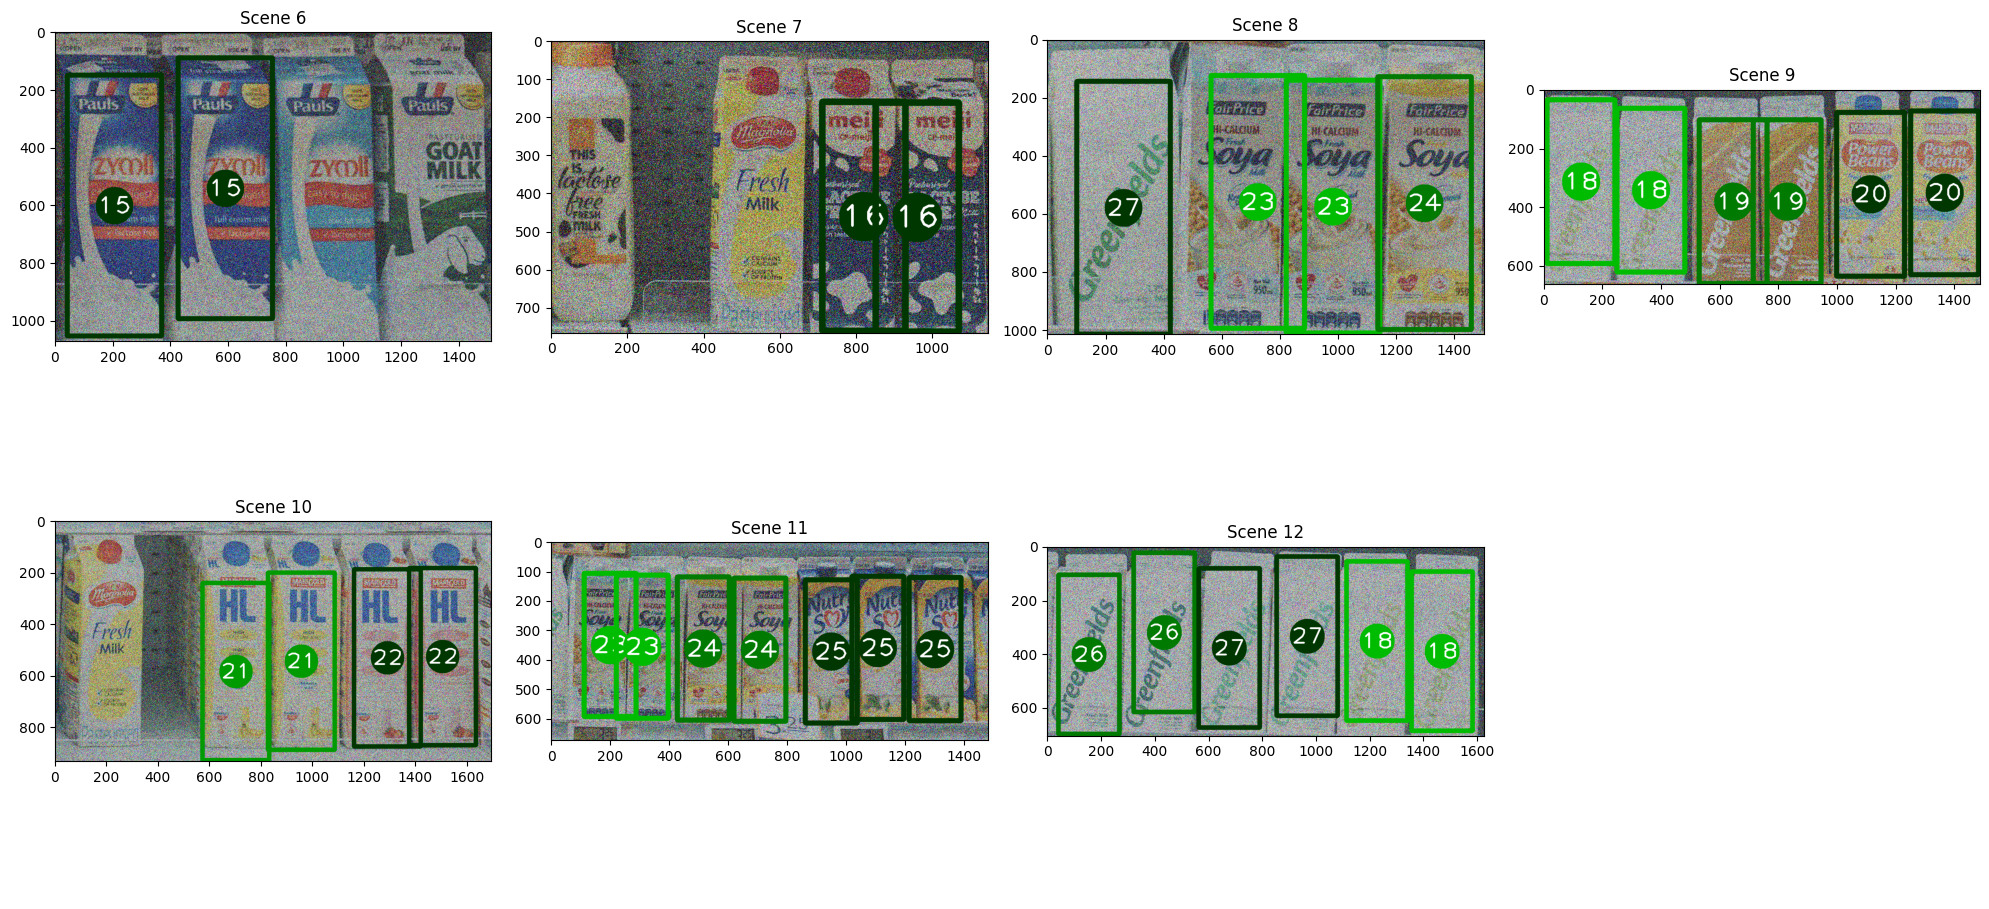

In [61]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
COLOR_RANGE=200
DRAW_CIRCLES=True
for i, scene in enumerate(products_found_B):
    image = cv2.cvtColor(cv2.imread(scenes_B[scene]), cv2.COLOR_BGR2RGB)
    # image=read_scenes_B[scene]
    prods=len(products_found_B[scene].keys())
    for c,products in enumerate(products_found_B[scene]):
        for instance in products_found_B[scene][products]:
            points = get_angles(instance['geometry'])
            color=[0,255-COLOR_RANGE+COLOR_RANGE*(prods-(c+1))/prods,0]
            # color=[np.random.randint(0,255) for _ in range(3)]
            image = cv2.polylines(image, [np.int32(points)], True, color, 15, cv2.LINE_AA)
            text=f'{products}'
            px,py=instance['geometry']['position']
            if DRAW_CIRCLES:
                image=cv2.circle(image,(px,py),65,color,-1)
                text_color=[255]*3
            else: 
                text_color=0
            px-=60
            py+=30
            image=cv2.putText(image,text,(px,py),cv2.FONT_HERSHEY_PLAIN,6,text_color,5)
    axes[i].imshow(image)#[:,:,::-1])
    # axes[i].axis('off')
    axes[i].set_title(f'Scene {scene}')
    if i == len(scenes_B)-1:
        for ax in axes[i+1:]:
            ax.axis('off')

plt.tight_layout()
plt.show()